<h1>Resource Estimation: Local-Basis Electronic Structure</h1>

<font size="3">

<hr>
DISTRIBUTION STATEMENT A. Approved for public release. Distribution is unlimited.

This material is based upon work supported by the Under Secretary of Defense for
Research and Engineering under Air Force Contract No. FA8702-15-D-0001. Any opinions,
findings, conclusions or recommendations expressed in this material are those of the
author(s) and do not necessarily reflect the views of the Under Secretary of Defense
for Research and Engineering.

© 2023 Massachusetts Institute of Technology.

The software/firmware is provided to you on an As-Is basis

Delivered to the U.S. Government with Unlimited Rights, as defined in DFARS Part
252.227-7013 or 7014 (Feb 2014). Notwithstanding any copyright notice, U.S. Government
rights in this work are defined by DFARS 252.227-7013 or DFARS 252.227-7014 as detailed
above. Use of this work other than as specifically authorized by the U.S. Government
may violate any copyrights that exist in this work.
<hr><hr>
</font>

In [1]:
import  numpy as np
from   pyLIQTR.utils.printing                                 import openqasm

import  cirq
import  qualtran

import matplotlib.pyplot as plt

from  qualtran.cirq_interop.jupyter_tools           import  svg_circuit

from qualtran.cirq_interop.testing                  import  GateHelper

from openfermion.chem                       import  MolecularData
from openfermionpyscf                       import  run_pyscf

from pyLIQTR.ProblemInstances.getInstance   import  getInstance
from pyLIQTR.BlockEncodings.getEncoding     import  getEncoding, VALID_ENCODINGS

from pyLIQTR.qubitization.phase_estimation  import  QubitizedPhaseEstimation
from pyLIQTR.utils.resource_analysis        import  estimate_resources

from pyLIQTR.utils.circuit_decomposition    import  circuit_decompose_multi
from pyLIQTR.utils.resource_analysis        import  estimate_resources
from pyLIQTR.utils.get_hdf5                 import  get_hdf5 

Note: It is our understanding that `openfermionpyscf` does not support Windows installations. The `pyLIQTR` functionality does not depend on openfermionpyscf, it is only utilized to generate molecular hamiltonians.

<hr>
<h3><u>Generating a Molecular Hamiltonian</u></h3>

The starting point for our workflow is either an openfermion or pyLIQTR Hamiltonian.  However, this notebook is accompanied by a database called `chemistry_instances.csv`, provided by  L3Harris/Zapata, which enumerates the inputs for a range of molecular systems (coordinates, basis set, etc. for diatomics, metal hydrides, small organic molecules, and a few inorganic complexes).  These can be loaded into a MolecularData object using the `get_hdf5()` function, which accepts a numerical index referring to a specific database entry. Entries are indexed from zero onward.

To expedite our demonstration, we load an entry for the $\text{H}_2$ molecule, as optimized using the STO-6G basis set (entry 140):

In [2]:
mol = get_hdf5(140)

/Users/ar26431/miniconda3/envs/pylqt2/lib/python3.10/site-packages/pyscf/gto/mole.py:1284: UserWarning: Function mol.dumps drops attribute charge because it is not JSON-serializable
  warnings.warn(msg)


Index numbers for a few other simple molecules are listed below:
- $\text{CH}_2$ : 57
- $\text{B}_2$ : 18
- $\text{ZnS}$ : 36
- $(\text{LiO}_2)_2$ : 338
- $\text{C}_6 \text{H}_6$ : 116
- $\text{B}_{11}^-$ : 217

For more indexed molecules, see `chemistry_instances.csv`.


Should one wish to compute a molecule not included in this file, the format below can be used to generate a `MolecularData` object given molecular parameters. Additionally shown is how to load a preexisting `hdf5` file.

In [3]:
###
#create MolecularData instance (geometry, basis, multiplicity, charge, name).
#mol_data = MolecularData([('H', (0.0, 0.0, 0.63164)), ('H', (0.0, 0.0, 1.76836))],\
#                    'sto-3g', 1.0, 0, 'H2')

#generate hdf5 file to be used for Hamiltonian calculations.
#mol = run_pyscf(mol_data, run_scf=1, run_mp2=0, run_cisd=0, run_ccsd=0, run_fci=0, verbose=0)
###

#if hdf5 file already exists:
#file_name = 'H2_Molecule.hdf5'
#mol = MolecularData(filename=file_name)
#mol.load()

Next, we compute the Hamiltonian as an openfermion `InteractionOperator` instance using `pySCF`, then create a ChemicalHamiltonian ProblemInstance.

In [4]:
mol_ham         =   mol.get_molecular_hamiltonian()
mol_instance    =   getInstance("ChemicalHamiltonian",mol_ham=mol_ham,mol_name="H2")

n_qubits = mol_instance.n_qubits()
print(f"Number of qubits: {n_qubits}")

[juliapkg] Found dependencies: /Users/ar26431/miniconda3/envs/pylqt2/lib/python3.10/site-packages/juliacall/juliapkg.json
[juliapkg] Found dependencies: /Users/ar26431/miniconda3/envs/pylqt2/lib/python3.10/site-packages/juliapkg/juliapkg.json
[juliapkg] Found dependencies: /Users/ar26431/miniconda3/envs/pylqt2/julia_env/pyjuliapkg/juliapkg.json
[juliapkg] Locating Julia ~1.8, ~1.9
[juliapkg] Querying Julia versions from https://julialang-s3.julialang.org/bin/versions.json
[juliapkg] Using Julia 1.9.4 at /Users/ar26431/miniconda3/envs/pylqt2/julia_env/pyjuliapkg/install/bin/julia
[juliapkg] Using Julia project at /Users/ar26431/miniconda3/envs/pylqt2/julia_env
[juliapkg] Installing packages:
           julia> import Pkg
           julia> Pkg.Registry.update()
           julia> Pkg.add([Pkg.PackageSpec(name="PythonCall", uuid="6099a3de-0909-46bc-b1f4-468b9a2dfc0d")])
           julia> Pkg.resolve()
           julia> Pkg.precompile()


    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
    Updating `~/miniconda3/envs/pylqt2/julia_env/Project.toml`
⌅ [6099a3de] + PythonCall v0.9.20
    Updating `~/miniconda3/envs/pylqt2/julia_env/Manifest.toml`
  [992eb4ea] + CondaPkg v0.2.23
  [9a962f9c] + DataAPI v1.16.0
  [e2d170a0] + DataValueInterfaces v1.0.0
  [82899510] + IteratorInterfaceExtensions v1.0.0
  [692b3bcd] + JLLWrappers v1.5.0
  [0f8b85d8] + JSON3 v1.14.0
  [1914dd2f] + MacroTools v0.5.13
  [0b3b1443] + MicroMamba v0.1.14
  [bac558e1] + OrderedCollections v1.6.3
  [69de0a69] + Parsers v2.8.1
  [fa939f87] + Pidfile v1.3.0
  [aea7be01] + PrecompileTools v1.2.1
  [21216c6a] + Preferences v1.4.3
⌅ [6099a3de] + PythonCall v0.9.20
  [ae029012] + Requires v1.3.0
  [6c6a2e73] + Scratch v1.2.1
  [856f2bd8] + StructTypes v1.11.0
  [3783bdb8] + TableTraits v1.0.1
  [bd369af6] + Tables v1.12.0
  [e17b2a0c] + UnsafePointers v1.0.0
  [f8abcde7] + micromamba_jll v1.5.8+0
  [0dad84c5] + Ar

Number of qubits: 4


<hr>
<h3><u>Building a Walk Operator</u></h3>

Our goal is to estimate the resource overhead for qubitized ground-state energy estimation (GSEE).  We will construct an implementation of the algorithm detailed in Phys. Rev. X <b>8</b>, 041015).  Here, the resource overhead is primarily determined by the cost of a block encoding $U_H = \text{Prepare}^{-1} \cdot \text{Select} \cdot \text{Prepare}$, which enters the GSEE algorithm through a walk operator $W$. From the Pauli string representation of the Hamiltonian, we can create $W$:

In [5]:
print(mol_instance)
# for x in mol_instance.yield_PauliLCU_Info():
#     print(x) 

lam       =   mol_instance.lam
delta_e   =   0.001
print(f"Encoding normalization (lambda): {lam}")

#get precision qubits m
m_base = (np.sqrt(2) * np.pi * lam) / (2 * delta_e)
m = int(np.ceil(np.log(m_base)))
print(f"Number of precision qubits needed: {m}")

from    pyLIQTR.qubitization.qubitized_gates                  import   QubitizedWalkOperator

walk_operator  =  QubitizedWalkOperator(getEncoding(instance=mol_instance, \
                                                    encoding=VALID_ENCODINGS.PauliLCU,instantiate=False))
print("Estimated resources = {}".format(estimate_resources(walk_operator)))

walk_circuit  =  GateHelper(walk_operator)

H2
Encoding normalization (lambda): 1.8482973783158303
Number of precision qubits needed: 9
Estimated resources = {'LogicalQubits': 9, 'T': 3364, 'Clifford': 6929}


/Users/ar26431/miniconda3/envs/pylqt2/lib/python3.10/site-packages/cotengra/hyperoptimizers/hyper.py:33: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(


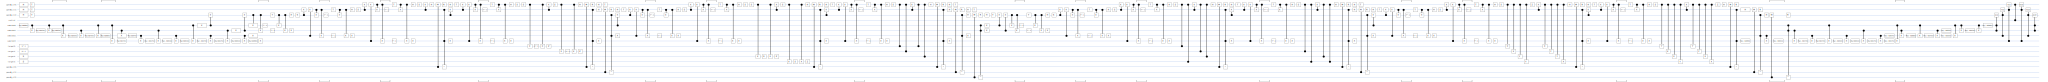

In [6]:
svg_circuit(circuit_decompose_multi(walk_circuit.circuit,4))

<hr>
<h3><u>Constructing Phase Estimation Circuit</u></h3>

We can now construct the phase estimation circuit shown below using our Hamiltonian-defined $W$. This can be done using the `QubitizedPhaseEstimation()` function, which returns a gate for the phase estimation circuit.

<center><img src="./figures/qubitized_phase_estimation.png" width="850"></center>

In [7]:
#build circuit

phase_est     =  QubitizedPhaseEstimation(getEncoding(VALID_ENCODINGS.PauliLCU),
                                            instance=mol_instance,prec=m)

PEGateHelper  =  GateHelper(phase_est)
circuit       =  PEGateHelper.circuit

circ_decomp = circuit_decompose_multi(circuit,1)

---
#### LIQTR Like 👍 : Circuit Decomposition
---
`cirq` / `qualtran` provide the ability to decompose circuits/operators into their constituent parts (ie, a QSVT sequence is a cosine and then sine sequence). Different circuits will have different levels of decomposition, since they are composed of different operators. 

We generally think of a "level 0" decomposition as being the original circuit, a "level N-1" decomposition being a circuit level that includes non-clifford+T gates, and a "level N" decomposition as the level that consists of just the valid gate set for the architcture (ie clifford+T).

The following lines show supported levels of decompositions:

In [ ]:
circuit_decompose_multi(circuit,1) 

In [9]:
circuit_decompose_multi(circuit,2) 

In [10]:
circuit_decompose_multi(circuit,3) 

---
#### LIQTR Like 👍 : Export of circuits to OpenQASM
---
Export of circuits can be done using a provided `pyLIQTR` utility (`pyLIQTR.utils.printing.openqasm`) that wraps `cirq`'s native openQASM export. This is introduced since some new cirq-ft operators do not yet have a decomposition in terms of gates defined, or `cirq` has begun to use features (mid-circuit measurement, classical control, etc) not supported by OpenQASM2.

This utility fully decomposes circuits to either include rotation gates (`rotation_allowed=True`) or not (`rotation_allowed=False`). 

In the latter case, we make use a of a Clifford+T representation outlined in https://arxiv.org/pdf/0806.3834.pdf (and further discussed in https://arxiv.org/pdf/1312.6584.pdf and http://www.cs.umd.edu/~amchilds/qa/qa.pdf, as potentially easier to digest forms).

When `rotation_allowed=False`, we introduce the "rx_d/ry_d/rz_d gate", followed by a line of the form:
```
// (leading_T, gate_sequence, sequence_length, clifford_part)
```
* `leading_T` : A bool indicating whether or not there is a `T` gate at the start of the sequence
* `gate_sequence`: An int whose binary representation encodes a sequence of `H`, `S`, and `T` gates
* `sequence_length`: The number of `T` gates in the sequence (note if `leading_T` is true, the total number of gates is `sequence_length+1`)
* `clifford_part`: A List[str] of clifford gates that come at the end of the H,S,T sequence.

Note that when `rotation_allowed=False`, you may also want to specify a level of precision by passing `gate_precision` or `circuit_precision` to `pyLIQTR.utils.printing.openqasm`

In [11]:
for ctr,line in enumerate(openqasm(circuit,rotation_allowed=False)):
    if ctr < 100:
        print(line)

// Generated from Cirq, Openfermion, and MIT LL

OPENQASM 2.0;
include "qelib1.inc";

// Qubits: [gancilla_c(3), gancilla_c(6), gancilla_c(10), gancilla_c(11), gancilla_c(25), gancilla_c(32), gancilla_c(42), gancilla_c(43), gancilla_c(44), gancilla_c(45), gancilla_c(46), gancilla_c(47), gancilla_c(48), gancilla_c(49), gancilla_c(50), prec0, prec1, prec2, prec3, prec4, prec5, prec6, prec7, prec8, prec9, selection0, selection1, selection2, selection3, target0, target1, target2, target3]
qreg q[33];


sdg q[25];
h q[25];
rz_d(pi*0.6882337607) q[25];
// (True, 93634264392250243549648955410, 97, [S, Y])
h q[25];
s q[25];
cx q[25],q[26];
sdg q[26];
h q[26];
rz_d(pi*0.0405889245) q[26];
// (True, 1334963109047240558827630788519, 104, [])
h q[26];
s q[26];
cx q[25],q[26];
sdg q[26];
h q[26];
rz_d(pi*0.6933412568) q[26];
// (True, 74619788599138739428837971467, 97, [Z, H, S])
h q[26];
s q[26];
cx q[25],q[27];
sdg q[27];
h q[27];
rz_d(pi*0.0547938098) q[27];
// (True, 144317263947017450780145659

<hr>
<h3><u>Estimating Resources for a Circuit</u></h3>

The qubitized phase estimation algorithm uses an $m$-qubit register to read out the target eigenvalue.  The value of $m$ that is needed to achieve fixed precision is set by the Hamiltonian normalization factor $\alpha$ (the sum of absolute values of all Hamiltonian coefficients, implicitly calculated above) and the target error in energy (in this case, $\epsilon = 0.001$ Hartree).

The phase estimation algorithm applies the walk operator $W$ to our target state in increasing powers of two, up to an maxmial exponent of $k = 2^{m - 1}$.  This gives a total of $2^{m-1}$ repetitions of $W$ when incluing the factor with a single controlled walk operator.  Moreover, each $W^k$ block is sandwiched between a pair of controlled reflections, giving a $2*(m-1)$ instances of the latter operator.

---
#### LIQTR Like 👍 : Resource Analysis
---
Resource analysis of `cirq` circuits can be done by using the `pyLIQTR.utils.resource_analysis.estimate_resources` function, which will provide T, qubit, and Clifford counts for most circuits!

Note that our estimate for T-count is done via experimentally derived statistical distribution for the Clifford count of rotations at a given precision.

In [12]:
estimate_resources(phase_est)

{'LogicalQubits': 18, 'T': 1722584, 'Clifford': 3548289}

While the above resource estimation is for a simple molecular example ($\text{H}_2$), we can perform estimation for more complex molecules using the same procedure. Relative orbital and T-counts for a sampling of molecules are shown below.

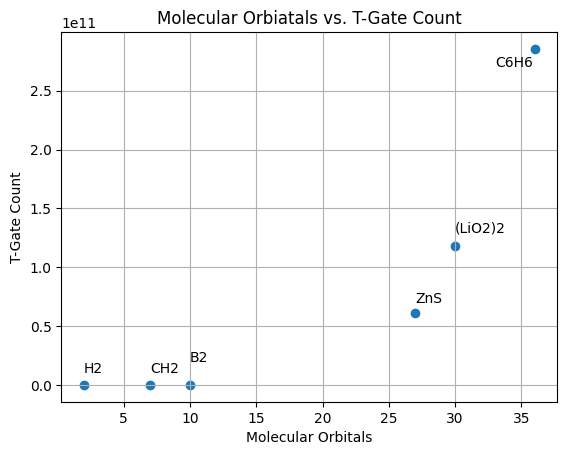

In [13]:
orbitals = np.array([2, 7, 10, 27, 30, 36])
t_count = np.array([112324, 3.68052e7, 1.4751e8, 6.12325e10, 1.18277e11, 2.85553e11])

fig, ax = plt.subplots()
ax.grid()
ax.scatter(orbitals, t_count)
ax.set_title("Molecular Orbiatals vs. T-Gate Count")
ax.set_xlabel("Molecular Orbitals")
ax.set_ylabel("T-Gate Count")
ax.annotate("H2", xy=(2, 11230), xytext=(2, 0.1e11))
ax.annotate("CH2", xy=(7, 3.68052e7), xytext=(7, 0.1e11))
ax.annotate("B2", xy=(10, 1.4751e8), xytext=(10, 0.2e11))
ax.annotate("ZnS", xy=(27, 6.12325e10), xytext=(27, 7e10))
ax.annotate("(LiO2)2", xy=(30, 1.18277e11), xytext=(30, 1.3e11))
ax.annotate("C6H6", xy=(36, 2.85553e11), xytext=(33, 2.7e11))
plt.show()

---
#### LIQTR Like 👍 : Circuit Scheduling
---
 
Circuits can be 'scheduled' using the `pyLIQTR.scheduler.scheduler.schedule_circuit` function. This will provide circuit runtime, realistic qubit counts, T-depth, and more!
 
`schedule_circuit` takes a number of optional arguments depending on desired outputs. They are:
* `architecture_config`: a dictionary specifying timing for various gate types and restrictions on how many T gates can operate simultaneously. This dictionary must be formatted as follows:
    * `{'Execution Times': {('Gate 1',): Time X, ('Gate 2', 'Gate 3'): Time Y}, 'Max T': Z # of simultaneous T-gates allowed}`
 
* `full_profile`: default `False`. If set to `True`, function output will include individual gate counts, T-widths, and parallelism distribution data. (NOTE: T-widths and parallelism data will only be available if `decomp_level` is set to `'Full'`.)
 
* `decomp_level`: int, default 0. Levels of decomposition implemented before scheduling. If set to `0`, each operator will be decomposed to one/two-qubit gates only on its first occurance and cached for each future occurance. If set to `'Full'`, entire circuit will be decomposed to one/two-qubit gates before scheduling.

* `context` : cirq.DecompositionContext, default is none which will result in the use of a context manager that tries to minimize the number of ancilla generated. At times, certain Qualtran Bloqs may have an error in their decomposition which results in ancilla not being properly cleared. If this happens, we recommend passing `context=cirq.DecompositionContext(cirq.SimpleQubitManager())` to resolve this issue, at the cost of an overzealous qubit allocation.

* `circuit_precision`: default 1e-3. Rotations are decomposed to a given precision. This can be passed explicitly using the `circuit_precision` keyword argument. If no precision argument is provided, the default value will be used. Note that higher-precision will generally increase the resource cost.

For further details on scheduler capabilities, see `Algorithms_and_Infrastructure/scheduling_example.ipynb`.

In [15]:
from pyLIQTR.scheduler.scheduler import schedule_circuit
res = schedule_circuit(circuit, full_profile=True, decomp_level='Full')
for r in res:
    print(f"{r} : {res[r]}")

Decomposition levels to basic gates: 7.
Time to schedule: 41.561369791044854 s.
Total time for execution : 584246
Circuit T-depth : 35594
Number of qubits used : 33
Gate profile : {'T': 35219, 'H': 26413, 'S': 20472, 'CX': 89299, 'CZ': 15139, 'Pauli (X, Y, Z)': 38933, 'Rotation': 14595}
Active qubit distribution : {19: 1, 6: 5863, 2: 50195, 1: 58908, 4: 18080, 3: 21927, 5: 3421, 7: 997, 11: 482, 8: 16}
T-widths : {0: 124297, 6: 9, 1: 25800, 2: 5399, 3: 4382, 4: 4}
